## Tests of the pre-DR7 code base

The purpose of this notebook is to compare a small number of Tractor catalogs from DR5 against the version of the pipeline we hope to use for DR7.  Some of the major changes include:
* More careful treatment of sources in and around bright stars.
* A source-detection step which uses the coadds to find faint sources.
* Use of Gaia and Tycho2 as (prior) input catalogs.

In [1]:
import os, warnings, pdb
from glob import glob
import numpy as np
import skimage.io
import fitsio
import matplotlib.pyplot as plt

In [2]:
from astrometry.libkd.spherematch import match_radec
from astropy.table import Table, vstack

In [3]:
plt.style.use('seaborn-talk')
%matplotlib inline

In [4]:
def read_tractor():
    """Read the old and new Tractor catalogs."""
    
    # First read the pre-DR7 catalogs.
    dr7dir = '/global/cscratch1/sd/ioannis/dr7test2'
    dr7files = glob('{}/tractor/???/tractor-*.fits'.format(dr7dir))
    cat = []
    for ii, dr7file in enumerate(dr7files):
        if (ii % 100) == 0:
            print('Read {:03d} / {:03d} pre-DR7 Tractor catalogs.'.format(ii, len(dr7files)))
        cat.append(Table(fitsio.read(dr7file, ext=1, lower=True)))
    dr7 = vstack(cat)
    
    # Now read the corresponding DR5 catalogs.
    dr5dir = '/global/project/projectdirs/cosmo/data/legacysurvey/dr5'
    dr5files = [ff.replace(dr7dir, dr5dir) for ff in dr7files]
    cat = []
    for ii, dr5file in enumerate(dr5files):
        if (ii % 100) == 0:
            print('Read {:03d} / {:03d} DR5 Tractor catalogs.'.format(ii, len(dr5files)))
        cat.append(Table(fitsio.read(dr5file, ext=1, lower=True)))
    dr5 = vstack(cat)
    
    dr5 = dr5[dr5['brick_primary']]
    dr7 = dr7[dr7['brick_primary']]
    
    return dr5, dr7

In [5]:
%time dr5, dr7 = read_tractor()
print('Read {} DR5 and {} pre-DR7 sources.'.format(len(dr5), len(dr7)))

Read 000 / 055 pre-DR7 Tractor catalogs.
Read 000 / 055 DR5 Tractor catalogs.
CPU times: user 8.42 s, sys: 2.85 s, total: 11.3 s
Wall time: 19.3 s
Read 353139 DR5 and 477241 pre-DR7 sources.


### What sources are in DR7 but not DR5, and in DR5 but not DR7?
Use a 1 arcsec search radius.

In [6]:
m1, m2, d12 = match_radec(dr7['ra'], dr7['dec'], dr5['ra'], dr5['dec'], 1./3600.0, nearest=True)
in_dr7_not_dr5 = np.delete(np.arange(len(dr7)), m1)
in_dr5_not_dr7 = np.delete(np.arange(len(dr5)), m2)

In [7]:
def qa_radec():
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
    ax1.hexbin(dr5['ra'], dr5['dec'], mincnt=1)
    ax1.set_title('All DR5 Sources (N={})'.format(len(dr5)))
                  
    ax3.hexbin(dr5['ra'][in_dr5_not_dr7], dr5['dec'][in_dr5_not_dr7], mincnt=1)
    ax3.set_title('In DR5, not DR7 (N={})'.format(len(in_dr5_not_dr7)))
    
    ax2.hexbin(dr7['ra'], dr7['dec'], mincnt=1)
    ax2.set_title('All DR7 Sources (N={})'.format(len(dr7)))
    
    ax4.hexbin(dr7['ra'][in_dr7_not_dr5], dr7['dec'][in_dr7_not_dr5], mincnt=1)
    ax4.set_title('In DR7, not DR5 (N={})'.format(len(in_dr7_not_dr5)))
    
    fig.subplots_adjust(wspace=0.02, hspace=0.2)

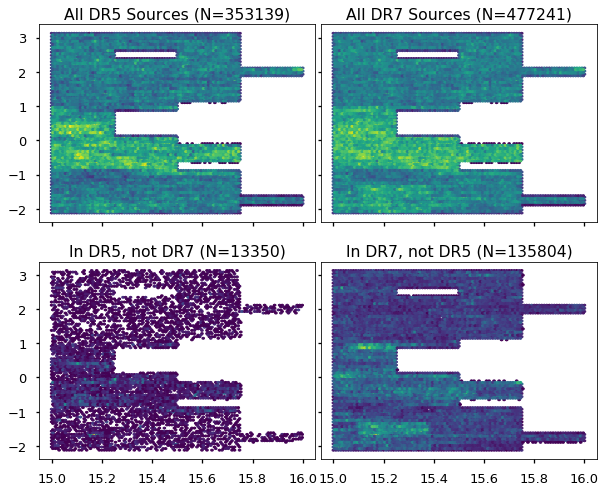

In [8]:
qa_radec()

### Study sources in and around bright stars.

In [9]:
def qa_brightstars(magcut=10):
    istar = np.logical_or(dr7['ref_cat'] == 'T2', dr7['ref_cat'] == 'G2')
    ibright = np.logical_and(istar, dr7['gaia_phot_g_mean_mag'] < magcut)
    instar = dr7['brightstarinblob']
    print('Found {} m<{:.1f} (bright) stars.'.format(np.sum(ibright), magcut))
    print('Found {} sources around all {} Gaia/Tycho-2 stars.'.format(np.sum(instar), np.sum(istar)))

    fig, ax = plt.subplots()
    ax.scatter(dr7['ra'][ibright], dr7['dec'][ibright], s=50, 
               label='Bright Stars (m<{:.1f})'.format(magcut))
    ax.scatter(dr7['ra'][instar], dr7['dec'][instar], s=2, alpha=0.7, 
               label='Sources around All Stars')
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.legend(loc='lower right')
    
    print('Sources in and around bright stars have type(s) = {}'.format(', '.join(np.unique(dr7['type'][instar]))))

Found 27 m<10.0 (bright) stars.
Found 10422 sources around all 8553 Gaia/Tycho-2 stars.
Sources in and around bright stars have type(s) = PSF 


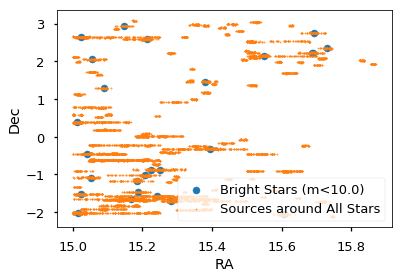

In [10]:
qa_brightstars()

### Study needle galaxies

Look for galaxies with anomalously small minor-to-major axis ratios.

In [11]:
def write_viewer_file(cat, objtype='EXP', dr='DR7'):
    outfile = os.path.join(os.getenv('HOME'), 'needles-{}-{}.fits'.format(objtype.lower(), dr.lower()))
    out = Table()
    out['ra'] = cat['ra']
    out['dec'] = cat['dec']
    out['name'] = cat['objid']
    print('Writing {}'.format(outfile))
    out.write(outfile, format='fits', overwrite=True)

In [12]:
def get_ba_radius_rmag(cat, objtype='EXP'):
    if objtype == 'EXP':
        radius = cat['shapeexp_r'].data
        e1, e2 = cat['shapeexp_e1'].data, cat['shapeexp_e2'].data
    elif objtype == 'DEV':
        radius = cat['shapedev_r'].data
        e1, e2 = cat['shapedev_e1'].data, cat['shapedev_e2'].data
    else:
        raise NotImplementedError
        
    ell = np.hypot(e1, e2).squeeze()
    ba = (1 - ell) / (1 + ell) 
    rmag = 22.5 - 2.5 * np.log10(cat['flux_r'].data)
    
    # surface brightness
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sb = rmag + 2.5 * np.log10( np.pi * radius**2 )
    
    return ba, radius, rmag, sb

In [13]:
def get_needles(cat, objtype='EXP', dr='DR7', ba_cut=0.1, radius_cut=25):

    if objtype == 'EXP':
        these = (cat['type'] == 'EXP ') * (cat['flux_r'] > 0)
        if dr == 'DR7':
            these = these * (cat['brightstarinblob'] == 0)
    elif objtype == 'DEV':
        these = (cat['type'] == 'DEV ') * (cat['flux_r'] > 0)
        if dr == 'DR7':
            these = these * (cat['brightstarinblob'] == 0)
    else:
        raise NotImplementedError
            
    ba, radius, rmag, sb = get_ba_radius_rmag(cat[these], objtype=objtype)

    indx = np.where( (ba < ba_cut) * (radius > radius_cut) )[0]
    needles = cat[these][indx]

    print('Found {} {} needles in {} with b/a<{:.2f} and radius>{:d} arcsec.'.format(
        len(needles), objtype, dr, ba_cut, radius_cut))

    write_viewer_file(needles, objtype=objtype, dr=dr)
    
    qa_needles(cat[these], needles, objtype=objtype, dr=dr)
    
    return needles, ba[indx], radius[indx], rmag[indx], sb[indx]

In [14]:
def qa_needles(cat, needles, objtype='EXP', dr='DR7'):
    """Try to identify needles based on their size and ellipticity (or b/a ratio).
    
    """
    ba, radius, rmag, sb = get_ba_radius_rmag(cat, objtype=objtype)
    ba_needles, radius_needles, rmag_needles, sb_needles = get_ba_radius_rmag(needles, objtype=objtype)
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3))
    
    ax1.scatter(rmag, ba, s=3, label=objtype, alpha=0.5)
    ax1.scatter(rmag_needles, ba_needles, s=15, label=objtype, alpha=0.5)

    ax2.scatter(radius, ba, s=3, label=objtype, alpha=0.5)
    ax2.scatter(radius_needles, ba_needles, s=15, label=objtype, alpha=0.5)
    
    ax3.scatter(rmag, radius, s=3, label=objtype, alpha=0.5)
    ax3.scatter(rmag_needles, radius_needles, s=15, label=objtype, alpha=0.5)
        
    ax4.scatter(rmag, sb, s=3, label=objtype, alpha=0.5)
    ax4.scatter(rmag_needles, sb_needles, s=15, label=objtype, alpha=0.5)
        
    ax1.set_xlabel('r (AB mag)')
    ax1.set_ylabel('Minor-to-Major Axis Ratio)')
    
    ax2.set_xlabel('Half-light Radius (arcsec)')
    ax2.set_ylabel('Minor-to-Major Axis Ratio)')

    ax3.set_xlabel('r (AB mag)')
    ax3.set_ylabel('Half-light Radius (arcsec)')
    
    ax4.set_xlabel('r (AB mag)')
    ax4.set_ylabel(r'$\mu$ (mag / arcsec$^{2}$)')
    
    ax1.set_xlim(14, 26)
    ax1.set_ylim(0, 1)

    ax2.set_xlim(0, 155)
    ax2.set_ylim(0, 1)
    
    ax3.set_xlim(14, 26)
    ax3.set_ylim(0, 155)
    
    ax4.set_xlim(14, 26)
    ax4.set_ylim(35, 15)
    
    fig.suptitle('{}: Type = {}'.format(dr, objtype), fontsize=16)
    fig.subplots_adjust(wspace=0.4)

Found 177 DEV needles in DR7 with b/a<0.10 and radius>25 arcsec.
Writing /global/homes/i/ioannis/needles-dev-dr7.fits


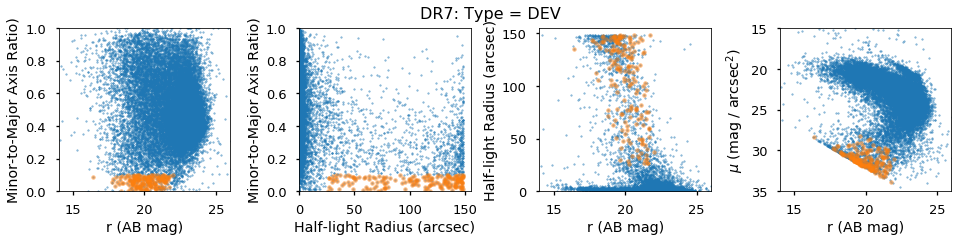

In [15]:
dev_needles_dr7, dev_needles_ba_dr7, dev_needles_radius_dr7, dev_needles_rmag_dr7, dev_sb_dr7 = get_needles(
    dr7, objtype='DEV', dr='DR7')

Found 101 DEV needles in DR5 with b/a<0.10 and radius>25 arcsec.
Writing /global/homes/i/ioannis/needles-dev-dr5.fits


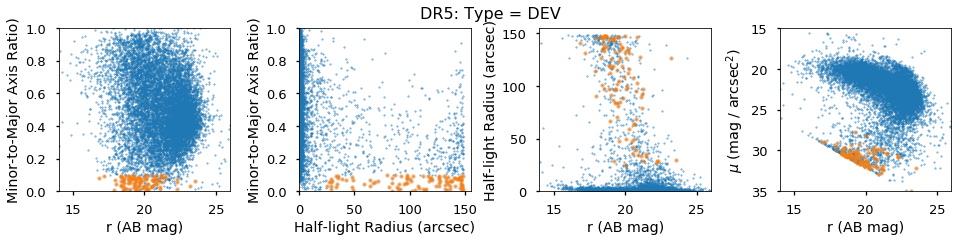

In [16]:
dev_needles_dr5, dev_needles_ba_dr5, dev_needles_radius_dr5, dev_needles_rmag_dr5, dev_needles_sb_dr5 = get_needles(
    dr5, objtype='DEV', dr='DR5')

Found 38 EXP needles in DR7 with b/a<0.10 and radius>25 arcsec.
Writing /global/homes/i/ioannis/needles-exp-dr7.fits


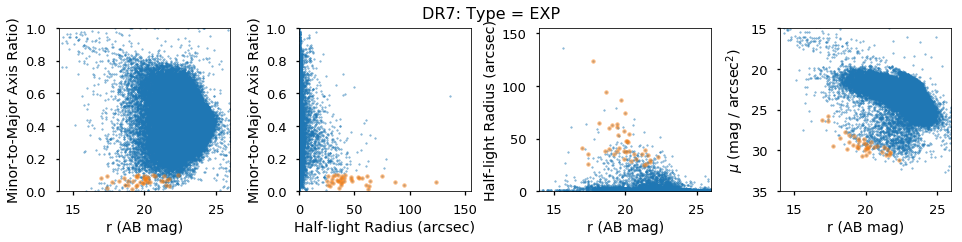

In [17]:
exp_needles_dr7, exp_needles_ba_dr7, exp_needles_radius_dr7, exp_needles_rmag_dr7, exp_needles_sb_dr7 = get_needles(
    dr7, objtype='EXP', dr='DR7')

Found 20 EXP needles in DR5 with b/a<0.10 and radius>25 arcsec.
Writing /global/homes/i/ioannis/needles-exp-dr5.fits


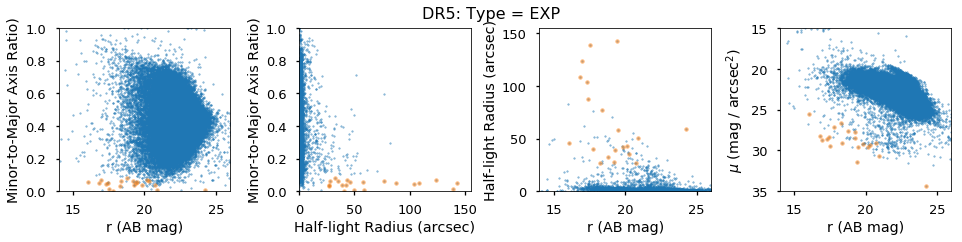

In [18]:
exp_needles_dr5, exp_needles_ba_dr5, exp_needles_radius_dr5, exp_needles_rmag_dr5, exp_needles_sb_dr5 = get_needles(
    dr5, objtype='EXP', dr='DR5')

In [19]:
def get_cutouts(cat, nperrow=5, dr='dr7', zoom='15'): 
    baseurl = 'http://legacysurvey.org//viewer-dev/'
        
    nrow = np.ceil(len(cat) / nperrow).astype('int')
    jpgsplit = list()
    for ii in range(nrow):
        i1 = nperrow*ii
        i2 = nperrow*(ii+1)
        if i2 > len(cat):
            i2 = len(cat)
        jpgsplit.append(cat[i1:i2])
    #print('Splitting the sample into {} rows with {} mosaics per row.'.format(nrow, nperrow))
    
    fig, ax = plt.subplots(nrow, nperrow, figsize=(3*nperrow, 3*nrow))
    
    ii = 0
    for jj, jpgrow in enumerate(jpgsplit):
        print('Row {}:'.format(jj+1))
        for obj in jpgrow:
            thisax = ax.flat[ii]
            url = '{}jpeg-cutout?ra={:.9f}1&dec={:.8f}&zoom={}&layer=decals-{}-model'.format(
                baseurl, obj['ra'], obj['dec'], zoom, dr.lower())
            print('{}?ra={:.9f}1&dec={:.8f}&zoom={}&layer=decals-{}-model'.format(
                baseurl, obj['ra'], obj['dec'], zoom, dr.lower()))
            #print(url)
            
            img = skimage.io.imread(url)
            thisax.imshow(img)
            thisax.axis('off')
            ii += 1
        print()

Row 1:
http://legacysurvey.org//viewer-dev/?ra=15.0953819751&dec=2.40427336&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.0126772721&dec=2.62215105&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.5126289751&dec=-0.36176636&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.5943969301&dec=-0.21477382&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.6745234851&dec=-0.14119022&zoom=15&layer=decals-dr7-model

Row 2:
http://legacysurvey.org//viewer-dev/?ra=15.5220826961&dec=-0.14383274&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.6657802841&dec=-0.13492690&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.2731663631&dec=2.03317682&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.2733147641&dec=2.03312811&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.2363234591&dec=1.15222280&zoom=15&lay

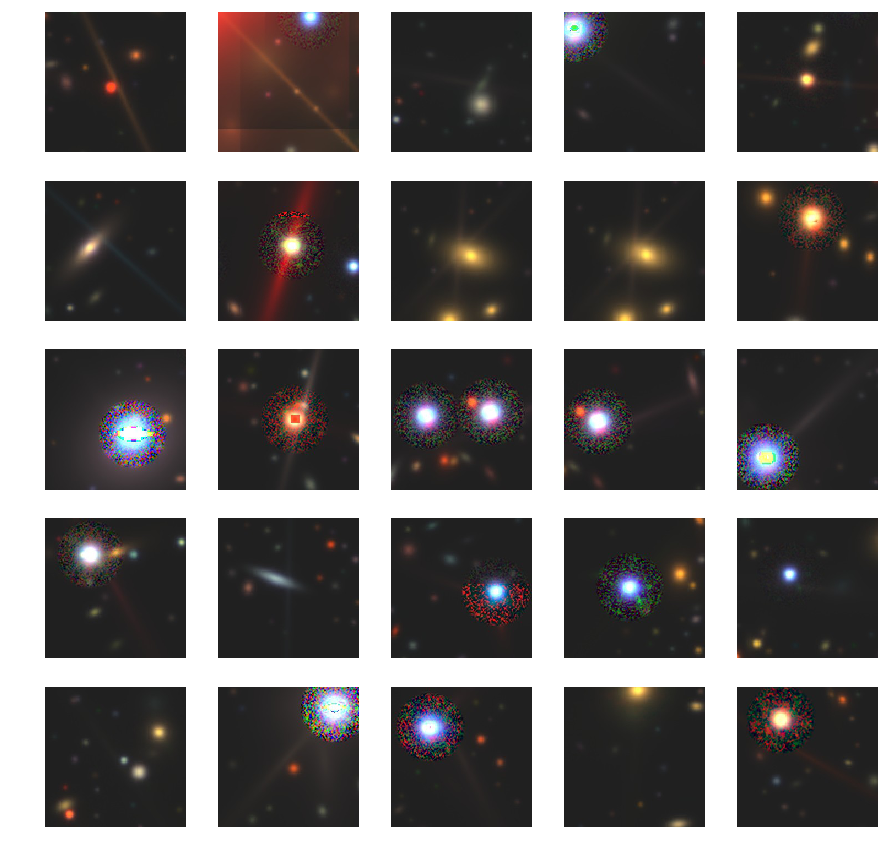

In [20]:
get_cutouts(dev_needles_dr7[:25], dr='DR7')

Row 1:
http://legacysurvey.org//viewer-dev/?ra=15.0739138071&dec=2.49687836&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.0339492911&dec=2.62163441&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.0336895921&dec=2.62250045&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.4565225951&dec=1.99841179&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.3052022881&dec=-0.69427240&zoom=15&layer=decals-dr7-model

Row 2:
http://legacysurvey.org//viewer-dev/?ra=15.2939785141&dec=-0.68344276&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.6762859021&dec=3.07950780&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.0456132011&dec=0.90396842&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.1148252111&dec=0.98449223&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.0541375981&dec=1.09951502&zoom=15&layer=

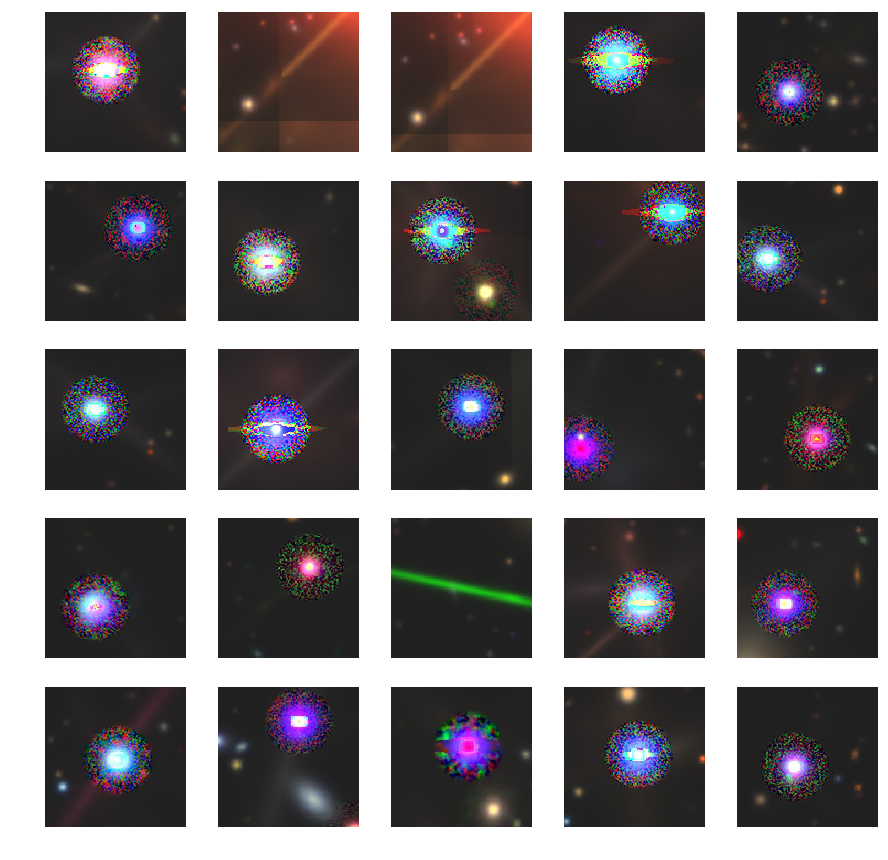

In [22]:
get_cutouts(exp_needles_dr7[:25], dr='DR7')

### Study large galaxies

In [23]:
def qa_largegals(cat, largegals, objtype='EXP', dr='DR7'):
    """Try to identify needles based on their size and ellipticity (or b/a ratio).
    
    """
    ba, radius, rmag, sb = get_ba_radius_rmag(cat, objtype=objtype)
    ba_largegals, radius_largegals, rmag_largegals, sb_largegals = get_ba_radius_rmag(largegals, objtype=objtype)
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3))
    
    ax1.scatter(rmag, ba, s=3, label=objtype, alpha=0.5)
    ax1.scatter(rmag_largegals, ba_largegals, s=15, label=objtype, alpha=0.5)

    ax2.scatter(radius, ba, s=3, label=objtype, alpha=0.5)
    ax2.scatter(radius_largegals, ba_largegals, s=15, label=objtype, alpha=0.5)
    
    ax3.scatter(rmag, radius, s=3, label=objtype, alpha=0.5)
    ax3.scatter(rmag_largegals, radius_largegals, s=15, label=objtype, alpha=0.5)

    ax4.scatter(rmag, sb, s=3, label=objtype, alpha=0.5)
    ax4.scatter(rmag_largegals, sb_largegals, s=15, label=objtype, alpha=0.5)
    
    ax1.set_xlabel('r (AB mag)')
    ax1.set_ylabel('Minor-to-Major Axis Ratio)')
    
    ax2.set_xlabel('Half-light Radius (arcsec)')
    ax2.set_ylabel('Minor-to-Major Axis Ratio)')

    ax3.set_xlabel('r (AB mag)')
    ax3.set_ylabel('Half-light Radius (arcsec)')

    ax4.set_xlabel('r (AB mag)')
    ax4.set_ylabel(r'$\mu$ (mag / arcsec$^{2}$)')
    
    ax1.set_xlim(14, 26)
    ax1.set_ylim(0, 1)

    ax2.set_xlim(0, 155)
    ax2.set_ylim(0, 1)
    
    ax3.set_xlim(14, 26)
    ax3.set_ylim(0, 155)

    ax4.set_xlim(14, 26)
    ax4.set_ylim(35, 15)
    
    fig.suptitle('{}: Type = {}'.format(dr, objtype), fontsize=16)
    fig.subplots_adjust(wspace=0.3)

In [24]:
def get_largegals(cat, objtype='EXP', dr='DR7', radius_cut=60, radius_max=150):

    if objtype == 'EXP':
        these = (cat['type'] == 'EXP ') * (cat['flux_r'] > 0)
        if dr == 'DR7':
            these = these * (cat['brightstarinblob'] == 0)
    elif objtype == 'DEV':
        these = (cat['type'] == 'DEV ') * (cat['flux_r'] > 0)
        if dr == 'DR7':
            these = these * (cat['brightstarinblob'] == 0)
    else:
        raise NotImplementedError
            
    ba, radius, rmag, sb = get_ba_radius_rmag(cat[these], objtype=objtype)

    indx = np.where( (radius > radius_cut) * (radius < radius_max) )[0]
    largegals = cat[these][indx]

    print('Found {} {} large galaxies in {} with radius>{:d} arcsec.'.format(
        len(largegals), objtype, dr, radius_cut))

    qa_largegals(cat[these], largegals, objtype=objtype, dr=dr)
    
    return largegals, radius[indx], rmag[indx], sb[indx]

Found 982 DEV large galaxies in DR7 with radius>60 arcsec.


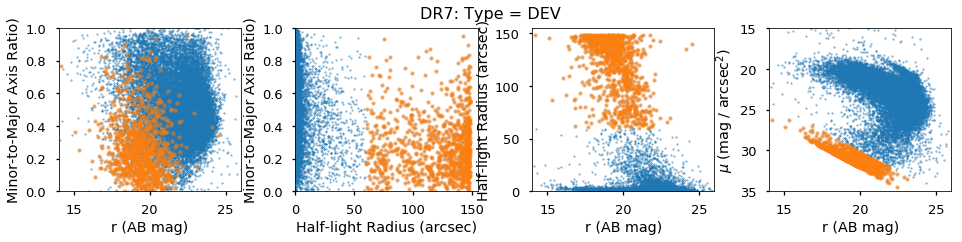

In [25]:
dev_largegals, dev_largegals_radius, dev_largegals_rmag, dev_largegals_sb = get_largegals(
    dr7, objtype='DEV', dr='DR7')

In [27]:
srt = np.argsort(dev_largegals_radius)[::-1]
print(dev_largegals_radius[srt[:25]])

[ 148.40159607  148.3951416   148.38980103  148.36270142  148.35852051
  148.32618713  148.31904602  148.31819153  148.30189514  148.29936218
  148.27709961  148.27062988  148.26235962  148.25468445  148.24615479
  148.23269653  148.16340637  148.15951538  148.15518188  148.15350342
  148.1526947   148.15194702  148.09544373  148.07525635  148.06214905]


Row 1:
http://legacysurvey.org//viewer-dev/?ra=15.1302048931&dec=-1.68950792&zoom=14&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.1095115251&dec=2.25254808&zoom=14&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.3284880061&dec=-0.89373271&zoom=14&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.0732722091&dec=-1.34655432&zoom=14&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.1202901181&dec=-0.65861400&zoom=14&layer=decals-dr7-model

Row 2:
http://legacysurvey.org//viewer-dev/?ra=15.5446610421&dec=2.32332340&zoom=14&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.7257159231&dec=-0.53364862&zoom=14&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.2068335861&dec=2.04052718&zoom=14&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.0106107581&dec=0.89087633&zoom=14&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.5612284081&dec=1.57237557&zoom=14&lay

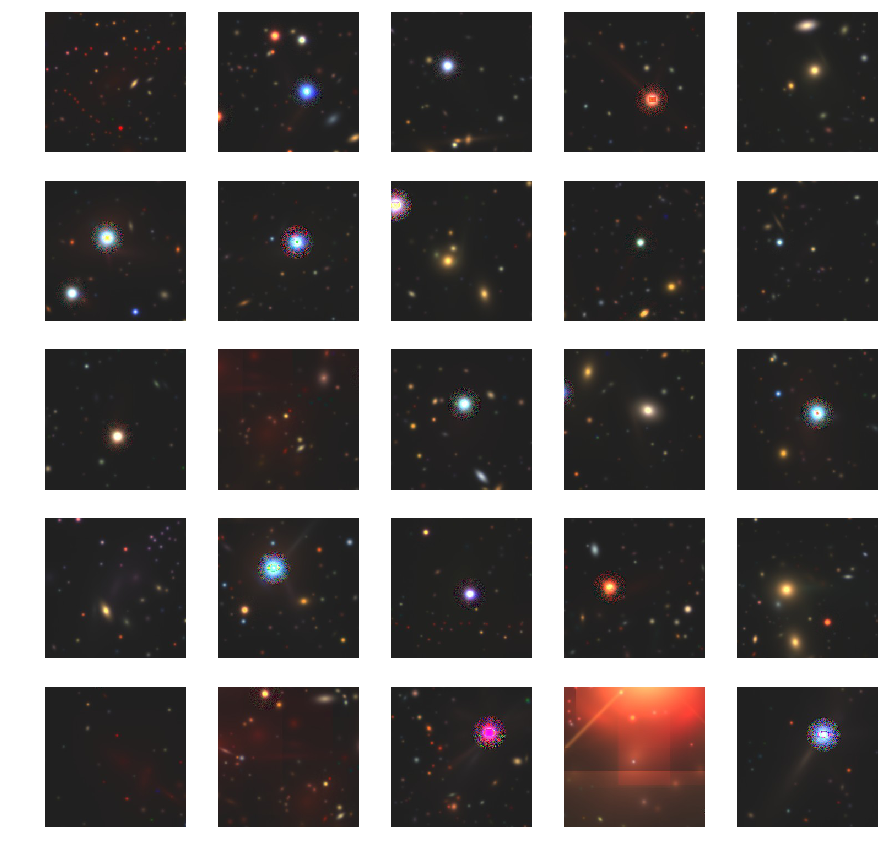

In [29]:
get_cutouts(dev_largegals[srt[:25]], dr='DR7', zoom='14')